In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
import random

from experiments.npe.model import get_npe_model
from experiments.npe.simulate import show_simulation
from renderer.threecircles import ThreeCircles
from experiments.playconf.environment import Environment, initialize_scene_from_configuration, make_training
from experiments.playconf.rl import get_actor, get_experience, get_critic, get_joint, get_random_experience, get_naive_adversarial_loss

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Loading chipmunk for Linux (64bit) [/home/shreyask/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/pymunk/libchipmunk.so]


In [2]:
with open('data/threecircles_munk_million.p', 'rb') as f:
    data = pickle.load(f)

train_x, train_y = data['train']
val_x, val_y = data['val']

def breakdown(X):
    return [
        np.array([x[0] for x in X]),
        np.array([x[1] for x in X]),
        np.array([x[2] for x in X]),
        np.array([x[3] for x in X]),
        np.array([x[4] for x in X]),
    ]

In [3]:
with open('data/threecircles_munk_million_mses.p', 'rb') as f:
    mses = pickle.load(f)

In [4]:
b_val_x = breakdown(val_x)

train_x = np.array(train_x)
train_y = np.array(train_y)

random_order = [i for i in range(len(train_x))]
random.shuffle(random_order)


train_x, train_y = train_x[random_order], train_y[random_order]

holdout_size = 10000
train_rl_x, train_rl_y = train_x[:len(train_x)-holdout_size], train_y[:len(train_x)-holdout_size]
holdout_rl_x, holdout_rl_y = train_x[len(train_x)-holdout_size:], train_y[len(train_x)-holdout_size:]
b_holdout_rl_x = breakdown(holdout_rl_x)

# train_ordered

# order = mses.argsort()
# ordered_train_x, ordered_train_y = train_x[order], train_y[order]

# random_order = [i for i in range(len(train_x))]
# random.shuffle(random_order)
# random_train_x, random_train_y = train_x[random_order], train_y[random_order]

In [9]:
def get_next_lv_batch(current_model, curriculum_batch, samples=50):
    best_batch = None
    best_pg = float('inf')
    
    model = tf.keras.models.clone_model(current_model)
    
    for ii in range(samples):
        model.set_weights(current_model.get_weights()) 
        
        sample_indexes = np.random.choice(len(train_rl_x), curriculum_batch)
        sample_x = breakdown(train_rl_x[sample_indexes])
        sample_y = train_rl_y[sample_indexes]
        
        model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0003))
        model.fit(sample_x, sample_y, epochs=1, batch_size=50, verbose=0)
        val_loss = model.evaluate(b_holdout_rl_x, holdout_rl_y, verbose=0)
#         print(ii, val_loss)
        
        if val_loss < best_pg:
            best_pg = val_loss
            best_batch = (sample_x, sample_y)
            
    return best_batch

def per_point_loss(model, x, y):
    predictions = model.predict(x)
    return ((y - predictions)**2).mean(axis=1)

def get_next_pg_batch(current_model, curriculum_batch, sample_size=100000):
    model = tf.keras.models.clone_model(current_model)
    
    sample_indexes = np.random.choice(len(train_x), sample_size)
    sample_x = train_x[sample_indexes]
    sample_y = train_y[sample_indexes]
    
    b_sample_x = breakdown(sample_x)
    
    baseline = per_point_loss(model, b_sample_x, sample_y)
    model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0003))
    model.fit(b_sample_x, sample_y, epochs=2, batch_size=50, verbose=0)
    after = per_point_loss(model, b_sample_x, sample_y)
    
    pg = baseline - after
    order = pg.argsort()[::-1][:curriculum_batch]
    
    print('Biggest drops', pg[order[:10]])
    
    chosen_x = sample_x[order]
    chosen_y = sample_y[order]
    
    return breakdown(chosen_x), chosen_y

def get_next_random_batch(curriculum_batch):
    sample_indexes = np.random.choice(len(train_x), curriculum_batch)
    sample_x = breakdown(train_x[sample_indexes])
    sample_y = train_y[sample_indexes]
    
    return sample_x, sample_y

In [10]:
model_rl = get_npe_model(max_pairs = 2)
model_random = get_npe_model(max_pairs = 2)

opt_o = tf.keras.optimizers.RMSprop(learning_rate=0.0003)
opt_r = tf.keras.optimizers.RMSprop(learning_rate=0.0003)
model_rl.compile(loss='mse', optimizer=opt_o)
model_random.compile(loss='mse', optimizer=opt_r)

curriculum_batch = 100
epochs = 5

losses_rl = {
    'train': [],
    'val': [],
}

losses_random = {
    'train': [],
    'val': [],
}

pbar = tqdm.tqdm_notebook(range(200))

for batch_index in pbar:
    rl_x, rl_y = get_next_lv_batch(model_rl, curriculum_batch)
    random_x, random_y = get_next_random_batch(curriculum_batch)

    history_rl = model_rl.fit(rl_x, rl_y, epochs=epochs, batch_size=50, verbose=0)
    val_loss_rl = model_rl.evaluate(b_val_x, np.array(val_y), verbose=0)
    train_loss_rl = history_rl.history['loss'][-1]
    
    history_random = model_random.fit(random_x, random_y, epochs=epochs, batch_size=50, verbose=0)
    val_loss_random = model_random.evaluate(b_val_x, np.array(val_y), verbose=0)
    train_loss_random = history_random.history['loss'][-1]
    
    
    print("Train random loss: %f, Train rl loss: %f, Val random loss: %f, Val rl loss: %f" % (
        train_loss_random, train_loss_rl, val_loss_random, val_loss_rl))
    
    losses_rl['train'].append(train_loss_rl)
    losses_rl['val'].append(val_loss_rl)
    
    losses_random['train'].append(train_loss_random)
    losses_random['val'].append(val_loss_random)

Train random loss: 0.021059, Train rl loss: 0.024696, Val random loss: 0.020463, Val rl loss: 0.020560
Train random loss: 0.023730, Train rl loss: 0.026789, Val random loss: 0.020888, Val rl loss: 0.020415
Train random loss: 0.019708, Train rl loss: 0.019609, Val random loss: 0.020803, Val rl loss: 0.020526
Train random loss: 0.017517, Train rl loss: 0.015493, Val random loss: 0.020838, Val rl loss: 0.020416
Train random loss: 0.015952, Train rl loss: 0.023021, Val random loss: 0.020431, Val rl loss: 0.020371
Train random loss: 0.015942, Train rl loss: 0.019542, Val random loss: 0.020480, Val rl loss: 0.020353
Train random loss: 0.023626, Train rl loss: 0.021768, Val random loss: 0.020701, Val rl loss: 0.020261
Train random loss: 0.023622, Train rl loss: 0.016801, Val random loss: 0.020936, Val rl loss: 0.020257
Train random loss: 0.024355, Train rl loss: 0.021342, Val random loss: 0.020420, Val rl loss: 0.020305
Train random loss: 0.024806, Train rl loss: 0.015633, Val random loss: 0.

Train random loss: 0.012555, Train rl loss: 0.012157, Val random loss: 0.014200, Val rl loss: 0.016949
Train random loss: 0.014220, Train rl loss: 0.018591, Val random loss: 0.015809, Val rl loss: 0.019449
Train random loss: 0.015926, Train rl loss: 0.009128, Val random loss: 0.018404, Val rl loss: 0.015228
Train random loss: 0.010844, Train rl loss: 0.012691, Val random loss: 0.014455, Val rl loss: 0.016431
Train random loss: 0.016236, Train rl loss: 0.014790, Val random loss: 0.014678, Val rl loss: 0.015115
Train random loss: 0.012135, Train rl loss: 0.014109, Val random loss: 0.014339, Val rl loss: 0.016466
Train random loss: 0.017061, Train rl loss: 0.015239, Val random loss: 0.015561, Val rl loss: 0.016545
Train random loss: 0.019417, Train rl loss: 0.012288, Val random loss: 0.013740, Val rl loss: 0.015317
Train random loss: 0.010163, Train rl loss: 0.012554, Val random loss: 0.013822, Val rl loss: 0.019263
Train random loss: 0.012246, Train rl loss: 0.015660, Val random loss: 0.

KeyboardInterrupt: 

In [ ]:
model_ordered = get_npe_model(max_pairs = 2)
model_random = get_npe_model(max_pairs = 2)

opt_o = tf.keras.optimizers.RMSprop(learning_rate=0.0003)
opt_r = tf.keras.optimizers.RMSprop(learning_rate=0.0003)
model_ordered.compile(loss='mse', optimizer=opt_o)
model_random.compile(loss='mse', optimizer=opt_r)

curriculum_batch = 4000
epochs = 50

losses_ordered = {
    'train': [],
    'val': [],
}

losses_random = {
    'train': [],
    'val': [],
}

pbar = tqdm.tqdm_notebook(range(0, len(train_x), curriculum_batch))

for batch_index in pbar:
    batch_ordered_x = breakdown(ordered_train_x[batch_index:batch_index+curriculum_batch])
    batch_ordered_y = ordered_train_y[batch_index:batch_index+curriculum_batch]
    
    batch_random_x = breakdown(random_train_x[batch_index:batch_index+curriculum_batch])
    batch_random_y = random_train_y[batch_index:batch_index+curriculum_batch]
    
    # Train on this till we plateau.
    history_ordered = model_ordered.fit(batch_ordered_x, batch_ordered_y, epochs=epochs, batch_size=50, verbose=0)
    val_loss_ordered = model_ordered.evaluate(b_val_x, np.array(val_y), verbose=0)
    train_loss_ordered = history_ordered.history['loss'][-1]
    
    history_random = model_random.fit(batch_random_x, batch_random_y, epochs=epochs, batch_size=50, verbose=0)
    val_loss_random = model_random.evaluate(b_val_x, np.array(val_y), verbose=0)
    train_loss_random = history_random.history['loss'][-1]
    
    
    print("Train random loss: %f, Train ordered loss: %f, Val random loss: %f, Val ordered loss: %f" % (
        train_loss_random, train_loss_ordered, val_loss_random, val_loss_ordered))
    
    losses_ordered['train'].append(train_loss_ordered)
    losses_ordered['val'].append(val_loss_ordered)
    
    losses_random['train'].append(train_loss_random)
    losses_random['val'].append(val_loss_random)

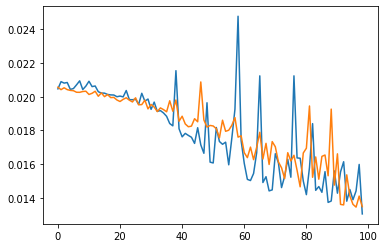

In [11]:
plt.plot(losses_random['val'])
plt.plot(losses_rl['val'])